# Temperature Scaling

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os
import copy

from tqdm import tqdm

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"{device} is available.")

cuda:0 is available.


In [3]:
HOME_ROOT = "/home/jovyan"

## DATA
DATA_ROOT = os.path.join(HOME_ROOT, "datasets/tadpole_frog_v3") # DATA ROOT 경로
TRAIN_DATA = os.path.join(DATA_ROOT, "train")
VAL_DATA = os.path.join(DATA_ROOT, "valid")
TEST_DATA = os.path.join(DATA_ROOT, "test")

## WEIGHT
WEIGHT_NAME = "obvious_v3_300.pth"
WEIGHT_SAVE_PATH = os.path.join(HOME_ROOT, "weights/ambiguous_exp", WEIGHT_NAME) # WEIGHT 파일 

In [4]:
resize = 224
mean = (0.5071, 0.4867, 0.4408)
std = (0.2675, 0.2565, 0.2761)
batch_size = 64

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_test = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [5]:
train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_DATA, transform=transform_train)
val_dataset = torchvision.datasets.ImageFolder(root=VAL_DATA, transform=transform_test)
test_dataset = torchvision.datasets.ImageFolder(root=TEST_DATA, transform=transform_test)

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
resnet50 = models.resnet50(pretrained=False)
resnet50.fc = nn.Linear(2048, 2)
resnet50 = resnet50.to(device)

In [8]:
resnet50.load_state_dict(torch.load(WEIGHT_SAVE_PATH))

<All keys matched successfully>

## T_Scaling factor 찾기

In [9]:
def T_scaling(logits, args):
    temperature = args.get('temperature', None)
    return torch.div(logits, temperature)

100%|██████████| 3/3 [00:01<00:00,  2.61it/s]


Final T_scaling factor: 4.72


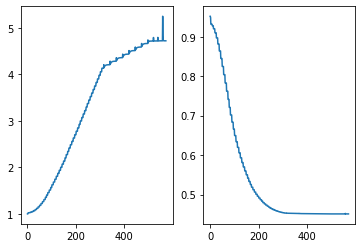

In [10]:
temperature = nn.Parameter(torch.ones(1).cuda())
args = {'temperature': temperature}
criterion = nn.CrossEntropyLoss()

# Removing strong_wolfe line search results in jump after 50 epochs
optimizer = optim.LBFGS([temperature], lr=0.001, max_iter=10000, line_search_fn='strong_wolfe')

logits_list = []
labels_list = []
temps = []
losses = []

for i, data in enumerate(tqdm(val_dataloader, 0)):
    images, labels = data[0].to(device), data[1].to(device)

    resnet50.eval()
    with torch.no_grad():
        logits_list.append(resnet50(images))
        labels_list.append(labels)

# Create tensors
logits_list = torch.cat(logits_list).to(device)
labels_list = torch.cat(labels_list).to(device)

def _eval():
    loss = criterion(T_scaling(logits_list, args), labels_list)
    loss.backward()
    temps.append(temperature.item())
    losses.append(loss)
    return loss


optimizer.step(_eval)

print('Final T_scaling factor: {:.2f}'.format(temperature.item()))

plt.subplot(121)
plt.plot(list(range(len(temps))), temps)

plt.subplot(122)
plt.plot(list(range(len(losses))), losses)
plt.show()

In [11]:
T_FACTOR = args['temperature'].item()
print("T_FACTOR: ", T_FACTOR)

T_FACTOR:  4.721051216125488


## TEST

In [12]:
# Use kwags for calibration method specific parameters
def test(calibration_method=None, **kwargs):
    preds = []
    labels_oneh = []
    correct = 0
    resnet50.eval()
    with torch.no_grad():
        for data in tqdm(test_dataloader):
            images, labels = data[0].to("cuda:0"), data[1].to("cuda:0")

            pred = resnet50(images)

            if calibration_method:
                pred = calibration_method(pred, kwargs)

            # Get softmax values for net input and resulting class predictions
            sm = nn.Softmax(dim=1)
            pred = sm(pred)

            _, predicted_cl = torch.max(pred.data, 1)
            pred = pred.cpu().detach().numpy()

            # Convert labels to one hot encoding
            label_oneh = torch.nn.functional.one_hot(labels, num_classes=2)
            label_oneh = label_oneh.cpu().detach().numpy()

            preds.extend(pred)
            labels_oneh.extend(label_oneh)

            # Count correctly classified samples for accuracy
            correct += sum(predicted_cl == labels).item()

    preds = np.array(preds).flatten()
    labels_oneh = np.array(labels_oneh).flatten()

    correct_perc = correct / len(test_dataset)
    print(
        "Accuracy of the network on the 10000 test images: %d %%" % (100 * correct_perc)
    )
    print(correct_perc)

    return preds, labels_oneh


preds, labels_oneh = test()

100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

Accuracy of the network on the 10000 test images: 85 %
0.85


## draw reliability graph

In [13]:
def calc_bins(preds):
    # Assign each prediction to a bin
    num_bins = 10
    bins = np.linspace(0.1, 1, num_bins)
    binned = np.digitize(preds, bins)

    # Save the accuracy, confidence and size of each bin
    bin_accs = np.zeros(num_bins)
    bin_confs = np.zeros(num_bins)
    bin_sizes = np.zeros(num_bins)

    for bin in range(num_bins):
        bin_sizes[bin] = len(preds[binned == bin])
        if bin_sizes[bin] > 0:
            bin_accs[bin] = (labels_oneh[binned == bin]).sum() / bin_sizes[bin]
            bin_confs[bin] = (preds[binned == bin]).sum() / bin_sizes[bin]

    return bins, binned, bin_accs, bin_confs, bin_sizes

In [14]:
def get_metrics(preds):
    ECE = 0
    MCE = 0
    bins, _, bin_accs, bin_confs, bin_sizes = calc_bins(preds)

    for i in range(len(bins)):
        abs_conf_dif = abs(bin_accs[i] - bin_confs[i])
        ECE += (bin_sizes[i] / sum(bin_sizes)) * abs_conf_dif
        MCE = max(MCE, abs_conf_dif)

    return ECE, MCE

In [15]:
import matplotlib.patches as mpatches


def draw_reliability_graph(preds):
    ECE, MCE = get_metrics(preds)
    bins, _, bin_accs, _, _ = calc_bins(preds)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()

    # x/y limits
    ax.set_xlim(0, 1.05)
    ax.set_ylim(0, 1)

    # x/y labels
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")

    # Create grid
    ax.set_axisbelow(True)
    ax.grid(color="gray", linestyle="dashed")

    # Error bars
    plt.bar(bins, bins, width=0.1, alpha=0.3, edgecolor="black", color="r", hatch="\\")

    # Draw bars and identity line
    plt.bar(bins, bin_accs, width=0.1, alpha=1, edgecolor="black", color="b")
    plt.plot([0, 1], [0, 1], "--", color="gray", linewidth=2)

    # Equally spaced axes
    plt.gca().set_aspect("equal", adjustable="box")

    # ECE and MCE legend
    ECE_patch = mpatches.Patch(color="green", label="ECE = {:.2f}%".format(ECE * 100))
    MCE_patch = mpatches.Patch(color="red", label="MCE = {:.2f}%".format(MCE * 100))
    plt.legend(handles=[ECE_patch, MCE_patch])

    # plt.show()

    plt.savefig("calibrated_network.png", bbox_inches="tight")


# draw_reliability_graph(preds)


100%|██████████| 2/2 [00:00<00:00,  3.00it/s]


Accuracy of the network on the 10000 test images: 85 %
0.85


100%|██████████| 2/2 [00:00<00:00,  3.05it/s]


Accuracy of the network on the 10000 test images: 85 %
0.85


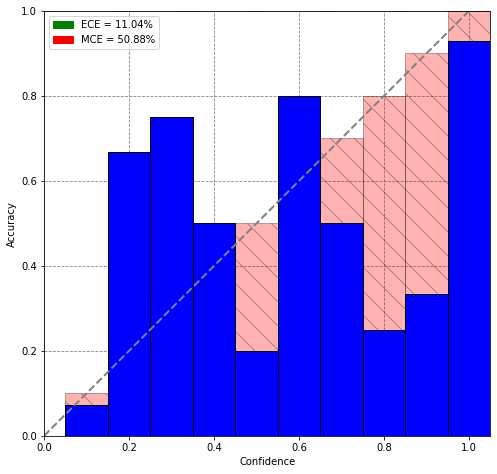

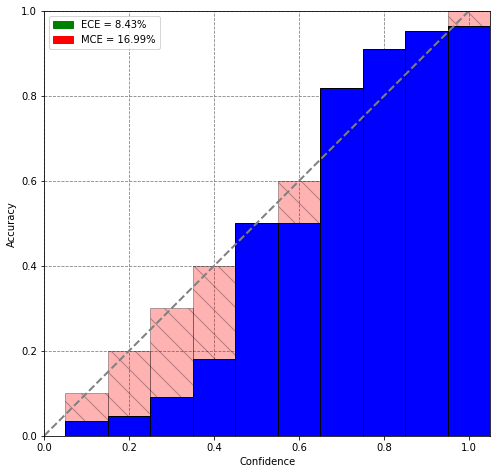

In [16]:
preds_original, _ = test()
preds_calibrated, _ = test(T_scaling, temperature=temperature)

draw_reliability_graph(preds_original)
draw_reliability_graph(preds_calibrated)

## Inference

In [43]:
AMBIGUOUS_DATA = os.path.join(HOME_ROOT, "datasets/tadpole_frog_v3/ambiguous")
ambiguous_images = os.listdir(AMBIGUOUS_DATA)
ambiguous_images = [os.path.join(AMBIGUOUS_DATA, image) for image in ambiguous_images]
ambiguous_images

['/home/jovyan/datasets/tadpole_frog_v3/ambiguous/2574236068_39a0bd0f00.jpg',
 '/home/jovyan/datasets/tadpole_frog_v3/ambiguous/2834730201_7acdfac8fd.jpg',
 '/home/jovyan/datasets/tadpole_frog_v3/ambiguous/65564068_143140bb99.jpg',
 '/home/jovyan/datasets/tadpole_frog_v3/ambiguous/2600672056_f3387d8eb4.jpg',
 '/home/jovyan/datasets/tadpole_frog_v3/ambiguous/393025936_13411c818f.jpg',
 '/home/jovyan/datasets/tadpole_frog_v3/ambiguous/3057898894_b404fa17e6.jpg',
 '/home/jovyan/datasets/tadpole_frog_v3/ambiguous/528481591_e1f085b611.jpg',
 '/home/jovyan/datasets/tadpole_frog_v3/ambiguous/1355712159_432ab0063c.jpg',
 '/home/jovyan/datasets/tadpole_frog_v3/ambiguous/415353627_e82333cd55.jpg',
 '/home/jovyan/datasets/tadpole_frog_v3/ambiguous/2713700186_638faf6e0f.jpg',
 '/home/jovyan/datasets/tadpole_frog_v3/ambiguous/1259204375_bdbfe48126.jpg',
 '/home/jovyan/datasets/tadpole_frog_v3/ambiguous/2871264645_e49076541c.jpg',
 '/home/jovyan/datasets/tadpole_frog_v3/ambiguous/20222120_dddd0c309e

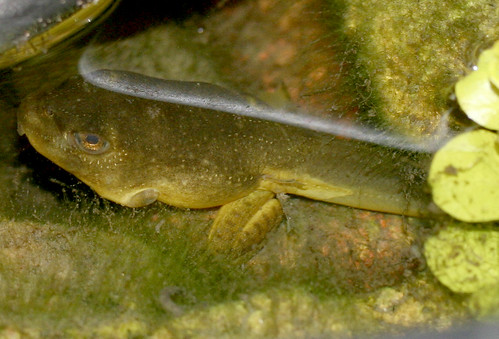

In [23]:
# 샘플 이미지 확인
from PIL import Image

ambiguous_image = ambiguous_images[10]
img = Image.open(ambiguous_image)
img.show()

In [ ]:
# image_tensor = transform_test(img).float()
# image_tensor = image_tensor.unsqueeze_(0)
# image_tensor = image_tensor.to(device)
# pred = resnet50(image_tensor)
# pred = T_scaling(pred, args) # Temperture Scaling
# sm = nn.Softmax(dim=1)
# pred = sm(pred)
# pred

tensor([[0.2973, 0.7027]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [36]:
# prob, idx = torch.max(pred.data, 1)
# print(idx)
# print(prob)

tensor([1], device='cuda:0')
tensor([0.7027], device='cuda:0')


In [37]:
# THRESHOLD = 0.6

# if prob.item() > THRESHOLD:
#     if idx.item() == 0:
#         print("frog")
#     elif idx.item() == 1:
#         print("tadpole")

frog


In [57]:
import shutil

ORI_DATA = os.path.join(HOME_ROOT, "datasets/tadpole_frog_v3")

In [61]:
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/ => {}'.format(indent, os.path.basename(root), len(files)))

In [63]:
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

for threshold in thresholds:
    # 기존 obvious dataset 복사
    NEW_DATASET = os.path.join(HOME_ROOT, "datasets", f"tadpole_frog_v4_THRES_{threshold}")
    shutil.copytree(ORI_DATA, NEW_DATASET)
    
    # inference
    for ambiguous_image in ambiguous_images:
        img = Image.open(ambiguous_image)
        image_tensor = transform_test(img).float()
        image_tensor = image_tensor.unsqueeze_(0)
        image_tensor = image_tensor.to(device)
        pred = resnet50(image_tensor)
        pred = T_scaling(pred, args) # Temperture Scaling
        sm = nn.Softmax(dim=1)
        pred = sm(pred)
        prob, cls = torch.max(pred.data, 1)
        
        # threshold에 따라 ambiguous image 파일 복사
        if prob > threshold:
            if cls.item() == 0:
                shutil.copy(ambiguous_image, os.path.join(NEW_DATASET, "train", "frog", ambiguous_image.split("/")[-1]))
            elif cls.item() == 1:
                shutil.copy(ambiguous_image, os.path.join(NEW_DATASET, "train", "tadpole", ambiguous_image.split("/")[-1]))
                
    list_files(NEW_DATASET)
    print("=" * 30)
    

tadpole_frog_v4_THRES_0.5/ => 0
    valid/ => 0
        tadpole/ => 75
        frog/ => 104
    ambiguous/ => 102
    test/ => 0
        tadpole/ => 42
        frog/ => 58
    train/ => 0
        tadpole/ => 374
        frog/ => 450
tadpole_frog_v4_THRES_0.6/ => 0
    valid/ => 0
        tadpole/ => 75
        frog/ => 104
    ambiguous/ => 102
    test/ => 0
        tadpole/ => 42
        frog/ => 58
    train/ => 0
        tadpole/ => 362
        frog/ => 438
tadpole_frog_v4_THRES_0.7/ => 0
    valid/ => 0
        tadpole/ => 75
        frog/ => 104
    ambiguous/ => 102
    test/ => 0
        tadpole/ => 42
        frog/ => 58
    train/ => 0
        tadpole/ => 348
        frog/ => 432
tadpole_frog_v4_THRES_0.8/ => 0
    valid/ => 0
        tadpole/ => 75
        frog/ => 104
    ambiguous/ => 102
    test/ => 0
        tadpole/ => 42
        frog/ => 58
    train/ => 0
        tadpole/ => 328
        frog/ => 427
tadpole_frog_v4_THRES_0.9/ => 0
    valid/ => 0
        tadpole/ => 

## References
- [Neural Network Calibration using PyTorch](https://towardsdatascience.com/neural-network-calibration-using-pytorch-c44b7221a61)
- [Neural Network Calibration using PyTorch Colab](https://colab.research.google.com/drive/1H_XlTbNvjxlAXMW5NuBDWhxF3F2Osg1F?usp=sharing)
- [gpleiss/temperature_scaling](https://github.com/gpleiss/temperature_scaling)